# Human Action Recognition (HAR using Pretrained Newtorks and Transfer Learning

We classify the human action using 3 different base models with transfer learning:
* ResNet v2
* VGG16
* Xception

Finally, we will display the activation maps using Grad-Cam.

Enjoy the notebook and feedback greatly appreciated.

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Overall Settings

In [ ]:
FINE_TUNING_EPOCHS = 12 
TRAINING_EPOCHS = 5
BATCH_SIZE = 32

image_height = 180 
image_width = 300

# Load data

In [ ]:
# path to the data files
main_path = "/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition"

# Load data
test_df     = pd.read_csv("/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/Testing_set.csv")
training_df = pd.read_csv("/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/Training_set.csv")

In [ ]:
# Stratified Sampling
# Use groupby and apply to select sample 
# which maintains the population group ratios
valid_df = training_df.groupby('label').apply(lambda x: x.sample(frac=0.10))
# There is one problem though - groupby() has added island as an index. 
# Let’s drop the extra index using the Pandas__ method droplevel()__. Pass the parameter 0 as we want to drop the top level index.
valid_df = valid_df.droplevel(0)
# Creating dataframe with
# rest of the 90% values
train_df = training_df.drop(valid_df.index)

In [ ]:
training_df.head()

filename         label
0  Image_1.jpg       sitting
1  Image_2.jpg  using_laptop
2  Image_3.jpg       hugging
3  Image_4.jpg      sleeping
4  Image_5.jpg  using_laptop

In [ ]:
freq = training_df['label'].value_counts()
train_freq = train_df['label'].value_counts()
valid_freq = valid_df['label'].value_counts()

print(freq,"\n\n", train_freq,"\n\n",valid_freq)
print()

sitting               840
using_laptop          840
hugging               840
sleeping              840
drinking              840
clapping              840
dancing               840
cycling               840
calling               840
laughing              840
eating                840
fighting              840
listening_to_music    840
running               840
texting               840
Name: label, dtype: int64 

 sitting               756
using_laptop          756
hugging               756
sleeping              756
drinking              756
clapping              756
dancing               756
cycling               756
calling               756
laughing              756
eating                756
fighting              756
listening_to_music    756
running               756
texting               756
Name: label, dtype: int64 

 calling               84
clapping              84
cycling               84
dancing               84
drinking              84
eating                84
fighting    

In [ ]:
test_df.head()

filename
0  Image_1.jpg
1  Image_2.jpg
2  Image_3.jpg
3  Image_4.jpg
4  Image_5.jpg

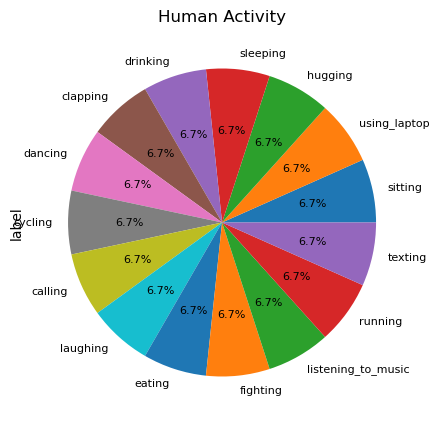

In [ ]:
freq.plot(kind='pie',figsize=(5,5),title='Human Activity',autopct='%1.1f%%',shadow = False,  fontsize=8);

# Data Generators

In [ ]:
# deep learning libraries
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image

In [ ]:
# Data agumentation and pre-processing using tensorflow
gen = ImageDataGenerator(rescale         = 1./255.,
                         horizontal_flip = True,
                         vertical_flip   = False,
                         zoom_range      = 0.05,
                         rotation_range  = 25)
 
train_generator = gen.flow_from_dataframe(
    train_df, # dataframe
    directory = main_path + "/train", # images data path / folder in which images are there
    x_col = 'filename',
    y_col = 'label',
    color_mode = "rgb",
    target_size = (image_height, image_width), # image height , image width
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 42)

Found 11340 validated image filenames belonging to 15 classes.


In [ ]:
# Data agumentation and pre-processing using tensorflow
test_gen = ImageDataGenerator(rescale = 1./255.)

validation_generator = test_gen.flow_from_dataframe(
    valid_df, # dataframe
    directory   = main_path + "/train", # images data path / folder in which images are there
    x_col       = 'filename',
    y_col       = 'label',
    color_mode  ="rgb",
    target_size = (image_height, image_width), # image height , image width
    class_mode  = "categorical",
    batch_size  = BATCH_SIZE,
    shuffle     = False,
    seed        = 42)

test_generator = test_gen.flow_from_dataframe(
    test_df, # dataframe
    directory   = main_path + "/test", # images data path / folder in which images are there
    x_col       = 'filename',
    #y_col       = 'labels',
    color_mode  = "rgb",
    target_size = (image_height, image_width), # image height , image width
    class_mode = None,
    batch_size  = BATCH_SIZE,
    shuffle  = False)

Found 1260 validated image filenames belonging to 15 classes.
Found 5400 validated image filenames.


In [ ]:
# Get labels in dataset
a = train_generator.class_indices
class_names = list(a.keys())  # storing class/breed names in a list

In [ ]:
class_names

['calling',
 'clapping',
 'cycling',
 'dancing',
 'drinking',
 'eating',
 'fighting',
 'hugging',
 'laughing',
 'listening_to_music',
 'running',
 'sitting',
 'sleeping',
 'texting',
 'using_laptop']

In [ ]:
# Define function to plot some images
import matplotlib.pyplot as plt

def plot_images(img, true_labels, predictions = None):
    plt.figure(figsize=[12, 18])
    for i in range(24):
        plt.subplot(6, 4, i+1)
        plt.imshow(img[i])
        plt.axis('off')
        if (predictions is not None):
            if true_labels is not None:
                plt.title("{}\n {} {:.1f}%".format(class_names[np.argmax(true_labels[i])], class_names[np.argmax(predictions[i])], 100 * np.max(predictions[i])))
            else:
                plt.title("{} {:.1f}%".format(class_names[np.argmax(predictions[i])], 100 * np.max(predictions[i]))) 
        else:
            if true_labels is not None:
                plt.title(class_names[np.argmax(true_labels[i])])    

# Sample Images

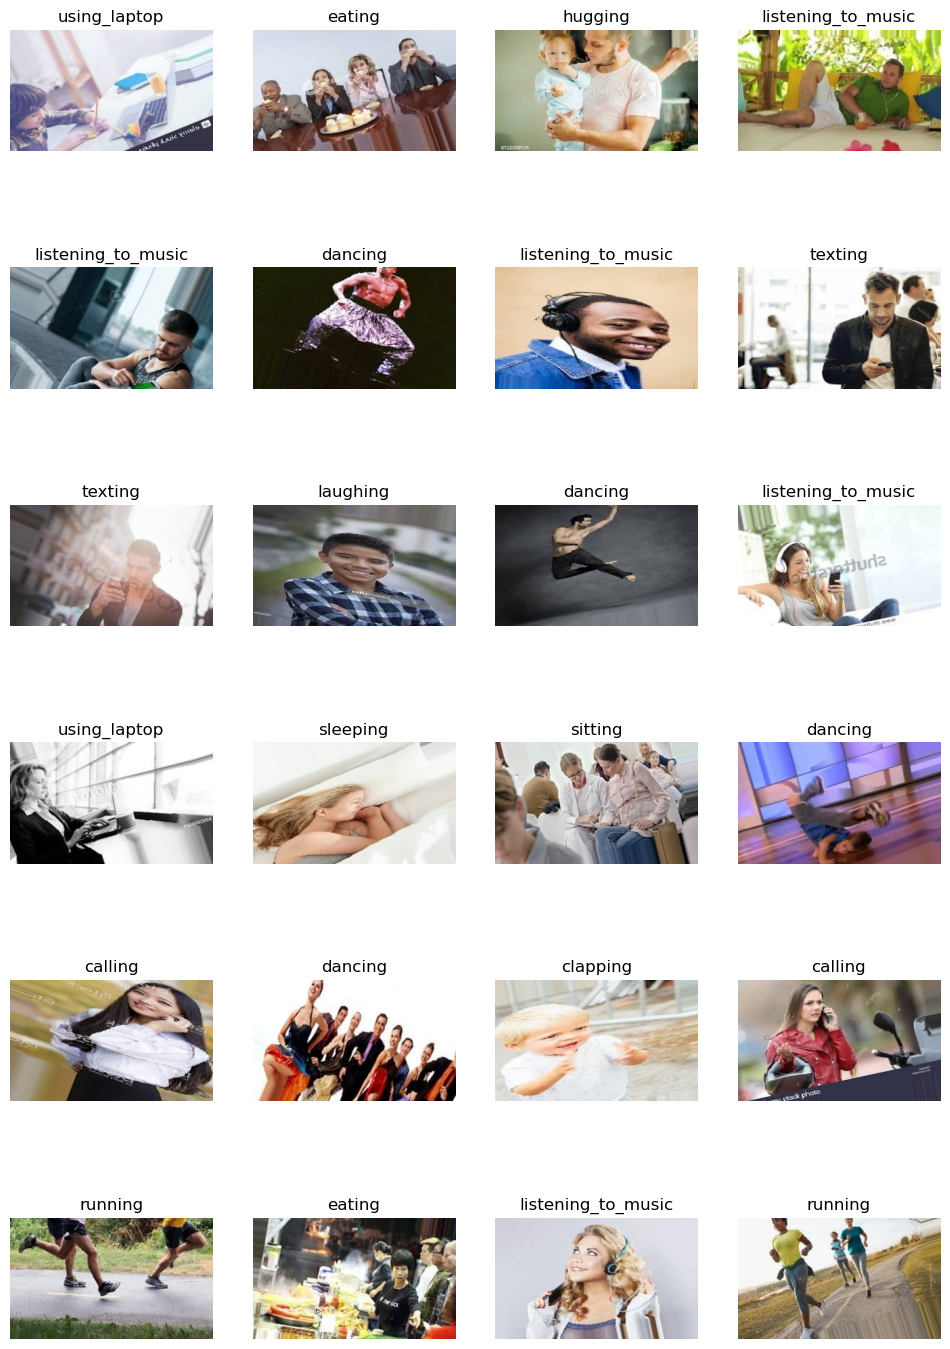

In [ ]:
x,y = next(train_generator)
plot_images(x,y)

In [ ]:
# function to plote training history
def plot_history(history):
    # store results
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # plot results
    # accuracy
    plt.figure(figsize=(5, 8))
    plt.rcParams['figure.figsize'] = [8, 4]
    plt.rcParams['font.size'] = 10
    plt.rcParams['axes.grid'] = True
    plt.rcParams['figure.facecolor'] = 'white'
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(round(acc[-1],3))}\nValidation Accuracy: {str(round(val_acc[-1],3))}')
    
    # loss
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title(f'Training and Validation Loss. \nTrain Loss: {str(round(loss[-1],3))}\nValidation Loss: {str(round(val_loss[-1],3))}')
    plt.xlabel('epoch')
    plt.tight_layout(pad=3.0)
    plt.show()

# Model

In [ ]:
from tensorflow.keras.models import Model

def create_model(base_model):
    
    x = base_model.output    
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation = 'relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(64, activation = 'relu')(x)
    x = Dropout(0.2)(x)
    
    outputs = Dense(len(class_names), activation='softmax')(x)
    
    model = Model(base_model.inputs, outputs)
    
    return model  

In [ ]:
def fit_model(model, base_model, epochs, fine_tune = 0):
    
    early = tf.keras.callbacks.EarlyStopping( patience = 10,
                                              min_delta = 0.001,
                                              restore_best_weights = True)
    # early stopping call back
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    
    print("Unfreezing number of layers in base model = ", fine_tune)
    
    if fine_tune > 0:
        base_model.trainable = True
        for layer in base_model.layers[:-fine_tune]:
            layer.trainable = False       
        # small learning rate for fine tuning
        model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
    else:
        base_model.trainable = False
        model.compile(optimizer=tf.keras.optimizers.Adam(),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
       
    # categorical cross entropy is taken since its used as a loss function for
    # multi-class classification problems where there are two or more output labels.
    # using Adam optimizer for better performance
    # other optimizers such as sgd can also be used depending upon the model

    # fit model
    history = model.fit(train_generator,
                        validation_data = validation_generator,
                        epochs = epochs,
                        callbacks = [early])
    
    return history

# Inception

In [ ]:
# load the InceptionResNetV2 architecture with imagenet weights as base
inception_base_model = tf.keras.applications.InceptionResNetV2(
                     include_top = False,
                     weights = 'imagenet',
                     input_shape = (image_height, image_width, 3)
                     )

# For freezing the layer we make use of layer.trainable = False
# means that its internal state will not change during training.
# model's trainable weights will not be updated during fit(),
# and also its state updates will not run.
inception_model = create_model(inception_base_model)
#inception_model.summary()
history = fit_model(inception_model, inception_base_model, epochs = TRAINING_EPOCHS)

219055592/219055592 [==============================] - 1s 0us/step
Unfreezing number of layers in base model =  0
Epoch 1/5
355/355 [==============================] - 226s 578ms/step - loss: 2.0494 - accuracy: 0.3359 - val_loss: 1.3644 - val_accuracy: 0.5810
Epoch 2/5
355/355 [==============================] - 153s 432ms/step - loss: 1.6635 - accuracy: 0.4596 - val_loss: 1.2636 - val_accuracy: 0.5968
Epoch 3/5
355/355 [==============================] - 155s 435ms/step - loss: 1.5998 - accuracy: 0.4902 - val_loss: 1.1877 - val_accuracy: 0.6357
Epoch 4/5
355/355 [==============================] - 158s 444ms/step - loss: 1.5378 - accuracy: 0.5088 - val_loss: 1.1481 - val_accuracy: 0.6508
Epoch 5/5
355/355 [==============================] - 157s 442ms/step - loss: 1.4966 - accuracy: 0.5240 - val_loss: 1.1508 - val_accuracy: 0.6532


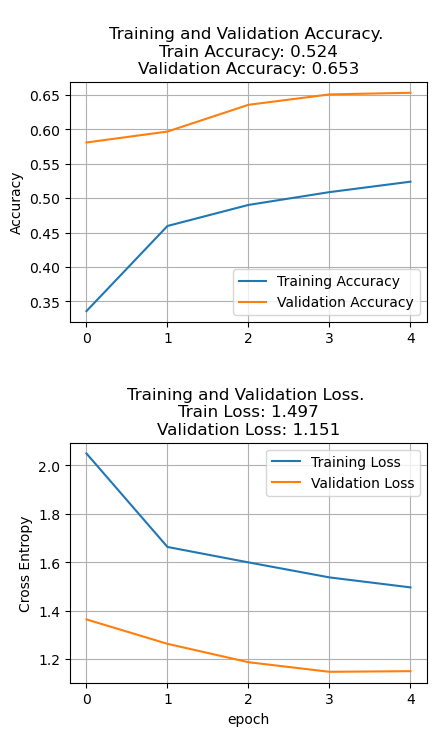

In [ ]:
plot_history(history)

In [ ]:
# Unfreeze the base_model
nr_base_layers = len(inception_base_model.layers)
print("Inception base layers = ", nr_base_layers)    

history = fit_model(inception_model, inception_base_model, epochs = FINE_TUNING_EPOCHS, fine_tune = int(nr_base_layers/4))

Inception base layers =  780
Unfreezing number of layers in base model =  195
Epoch 1/12
355/355 [==============================] - 206s 467ms/step - loss: 1.5133 - accuracy: 0.5309 - val_loss: 1.1225 - val_accuracy: 0.6730
Epoch 2/12
355/355 [==============================] - 162s 456ms/step - loss: 1.3487 - accuracy: 0.5821 - val_loss: 1.0376 - val_accuracy: 0.6937
Epoch 3/12
355/355 [==============================] - 163s 458ms/step - loss: 1.2813 - accuracy: 0.6048 - val_loss: 0.9928 - val_accuracy: 0.7119
Epoch 4/12
355/355 [==============================] - 166s 468ms/step - loss: 1.2127 - accuracy: 0.6255 - val_loss: 0.9567 - val_accuracy: 0.7159
Epoch 5/12
355/355 [==============================] - 164s 461ms/step - loss: 1.1433 - accuracy: 0.6491 - val_loss: 0.9383 - val_accuracy: 0.7286
Epoch 6/12
355/355 [==============================] - 164s 461ms/step - loss: 1.1061 - accuracy: 0.6575 - val_loss: 0.9146 - val_accuracy: 0.7325
Epoch 7/12
355/355 [==========================

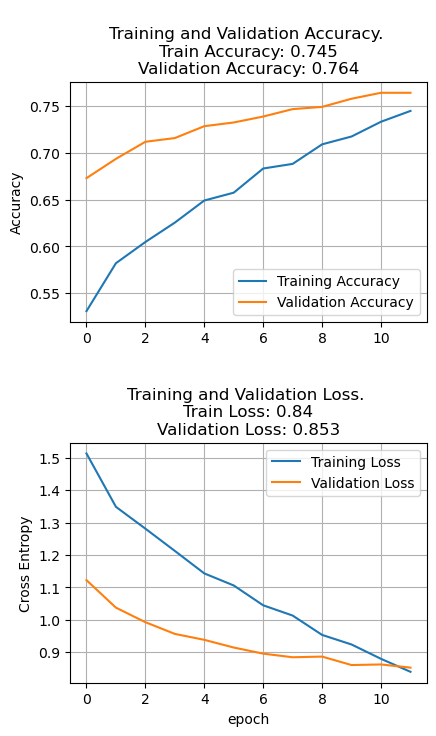

In [ ]:
 plot_history(history)

In [ ]:
accuracy_score = inception_model.evaluate(validation_generator)

print(accuracy_score)
print("Accuracy: {:.2f}%".format(accuracy_score[1] * 100))
print("Loss: {:.3f}".format(accuracy_score[0]))

40/40 [==============================] - 5s 120ms/step - loss: 0.8526 - accuracy: 0.7643
[0.8525977730751038, 0.7642857432365417]
Accuracy: 76.43%
Loss: 0.853


In [ ]:
# Perform predictions to allow computation of the confusion matrix later on
# Do not shuffle predictions otherwise we have no way of finding out the true labels
validation_generator.reset()
inception_val_preds = inception_model.predict(validation_generator)
inception_val_pred_classes = np.argmax(inception_val_preds, axis=1)

40/40 [==============================] - 8s 112ms/step


In [ ]:
# Perform predictions to allow computation of the confusion matrix later on
# Do not shuffle predictions otherwise we have no way of finding out the true labels
test_generator.reset()
inception_test_preds = inception_model.predict(test_generator)
inception_test_pred_classes = np.argmax(inception_test_preds, axis=1)

169/169 [==============================] - 44s 239ms/step


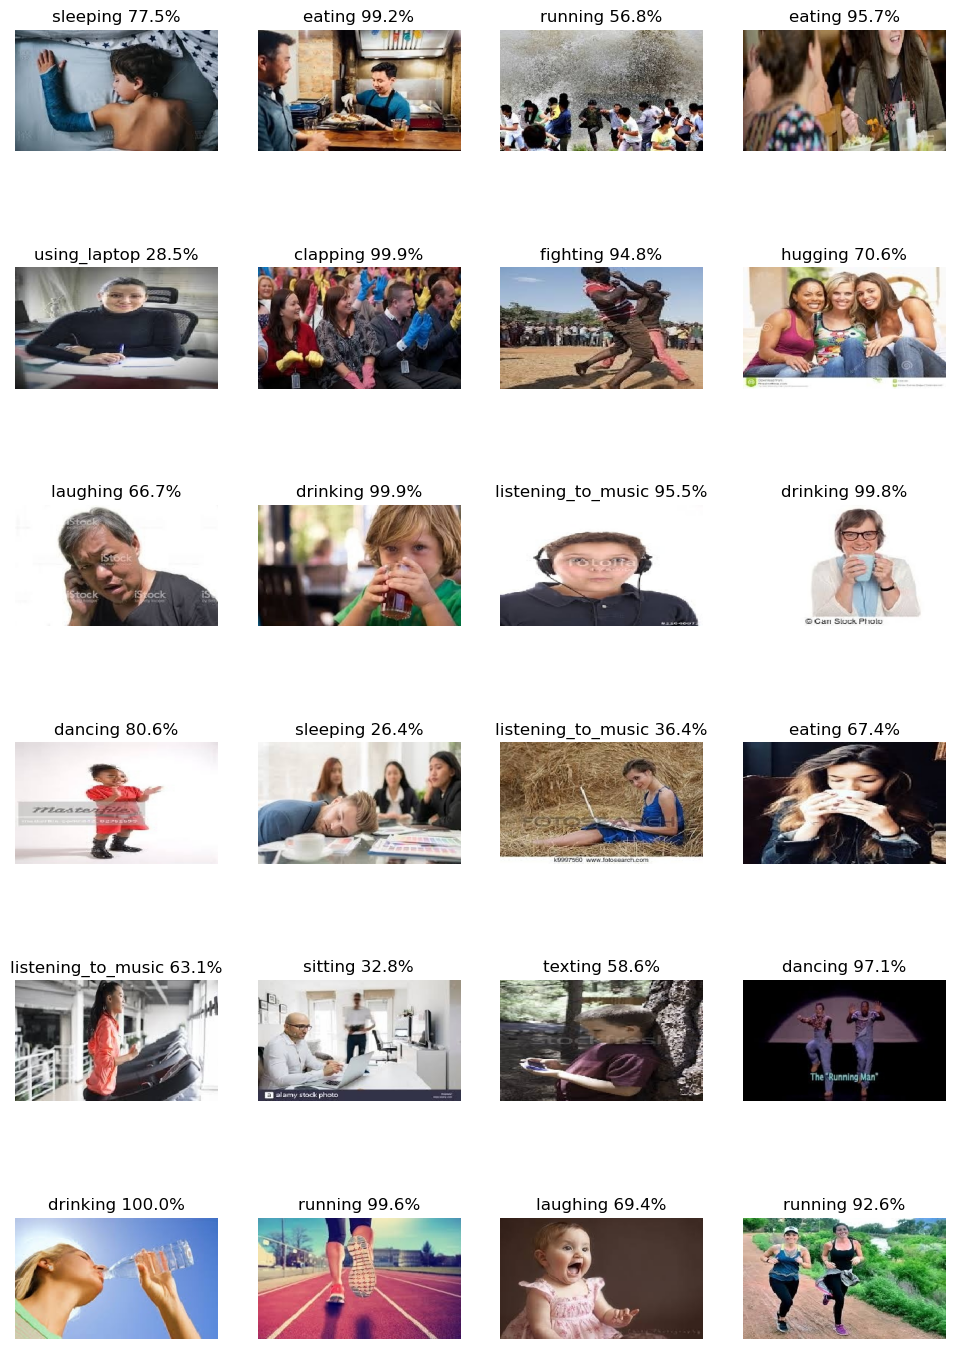

In [ ]:
test_generator.reset()
x = next(test_generator)
plot_images(x, None, inception_test_preds)

# VGG16

In [ ]:
# load the VGG16 architecture with imagenet weights as base
vgg16_base_model = tf.keras.applications.vgg16.VGG16(
                             include_top = False,
                             weights = 'imagenet',
                             input_shape = (image_height, image_width, 3)
                             )

# For freezing the layer we make use of layer.trainable = False
# means that its internal state will not change during training.
# model's trainable weights will not be updated during fit(),
# and also its state updates will not run.
vgg16_model = create_model(vgg16_base_model)
#vgg16_model.summary()
history = fit_model(vgg16_model, vgg16_base_model, epochs = TRAINING_EPOCHS)

58889256/58889256 [==============================] - 0s 0us/step
Unfreezing number of layers in base model =  0
Epoch 1/5
355/355 [==============================] - 153s 417ms/step - loss: 2.4751 - accuracy: 0.1784 - val_loss: 2.0727 - val_accuracy: 0.3111
Epoch 2/5
355/355 [==============================] - 149s 419ms/step - loss: 2.1073 - accuracy: 0.2985 - val_loss: 1.8183 - val_accuracy: 0.3992
Epoch 3/5
355/355 [==============================] - 147s 414ms/step - loss: 1.9880 - accuracy: 0.3390 - val_loss: 1.7417 - val_accuracy: 0.4111
Epoch 4/5
355/355 [==============================] - 148s 417ms/step - loss: 1.9189 - accuracy: 0.3651 - val_loss: 1.6899 - val_accuracy: 0.4397
Epoch 5/5
355/355 [==============================] - 148s 418ms/step - loss: 1.8706 - accuracy: 0.3797 - val_loss: 1.6383 - val_accuracy: 0.4619


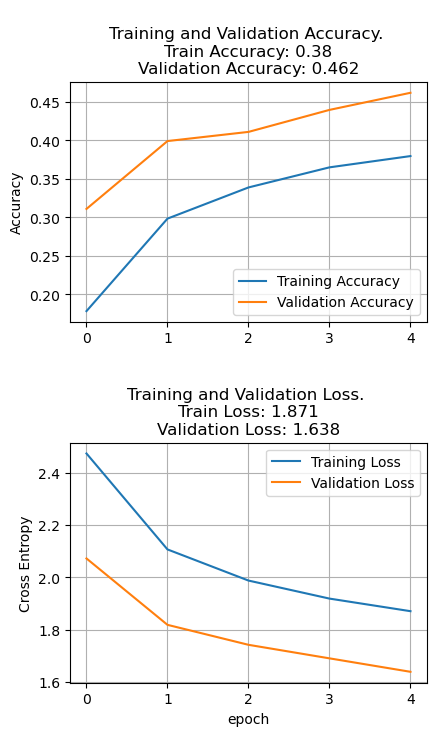

In [ ]:
plot_history(history)

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
nr_base_layers = len(vgg16_base_model.layers)
print("VGG16 base layers = ", nr_base_layers)    

history = fit_model(vgg16_model, vgg16_base_model, epochs = FINE_TUNING_EPOCHS, fine_tune = int(nr_base_layers/4))

VGG16 base layers =  19
Unfreezing number of layers in base model =  4
Epoch 1/12
355/355 [==============================] - 153s 421ms/step - loss: 1.7626 - accuracy: 0.4143 - val_loss: 1.5263 - val_accuracy: 0.4921
Epoch 2/12
355/355 [==============================] - 148s 418ms/step - loss: 1.6688 - accuracy: 0.4499 - val_loss: 1.4581 - val_accuracy: 0.5143
Epoch 3/12
355/355 [==============================] - 148s 418ms/step - loss: 1.6165 - accuracy: 0.4708 - val_loss: 1.4156 - val_accuracy: 0.5238
Epoch 4/12
355/355 [==============================] - 151s 423ms/step - loss: 1.5501 - accuracy: 0.4928 - val_loss: 1.3680 - val_accuracy: 0.5444
Epoch 5/12
355/355 [==============================] - 149s 418ms/step - loss: 1.5072 - accuracy: 0.5036 - val_loss: 1.4155 - val_accuracy: 0.5429
Epoch 6/12
355/355 [==============================] - 152s 429ms/step - loss: 1.4708 - accuracy: 0.5194 - val_loss: 1.3429 - val_accuracy: 0.5579
Epoch 7/12
355/355 [==============================] -

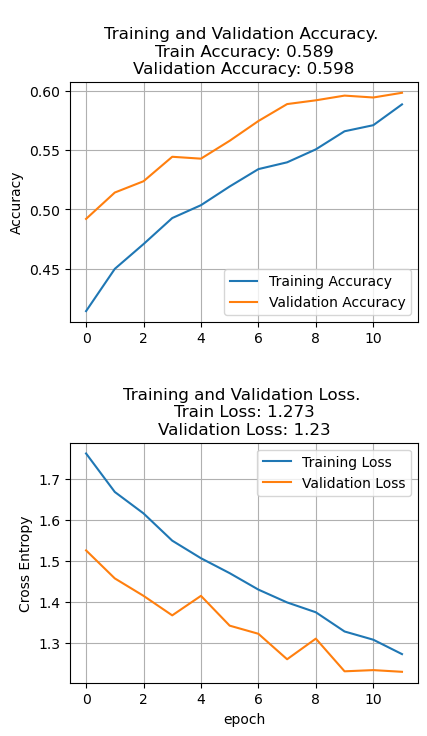

In [ ]:
plot_history(history)

In [ ]:
accuracy_score = vgg16_model.evaluate(validation_generator)

print(accuracy_score)
print("Accuracy: {:.2f}%".format(accuracy_score[1] * 100))
print("Loss: {:.3f}".format(accuracy_score[0]))

40/40 [==============================] - 3s 85ms/step - loss: 1.2304 - accuracy: 0.5984
[1.230352520942688, 0.5984126925468445]
Accuracy: 59.84%
Loss: 1.230


In [ ]:
# Perform predictions to allow computation of the confusion matrix later on
# Do not shuffle predictions otherwise we have no way of finding out the true labels
validation_generator.reset()

vgg16_val_preds = vgg16_model.predict(validation_generator)
vgg16_val_pred_classes = np.argmax(vgg16_val_preds, axis=1)

40/40 [==============================] - 3s 78ms/step


In [ ]:
# Perform predictions to allow computation of the confusion matrix later on
# Do not shuffle predictions otherwise we have no way of finding out the true labels
test_generator.reset()

vgg16_test_preds = vgg16_model.predict(test_generator)
vgg16_test_pred_classes = np.argmax(vgg16_test_preds, axis=1)

169/169 [==============================] - 21s 123ms/step


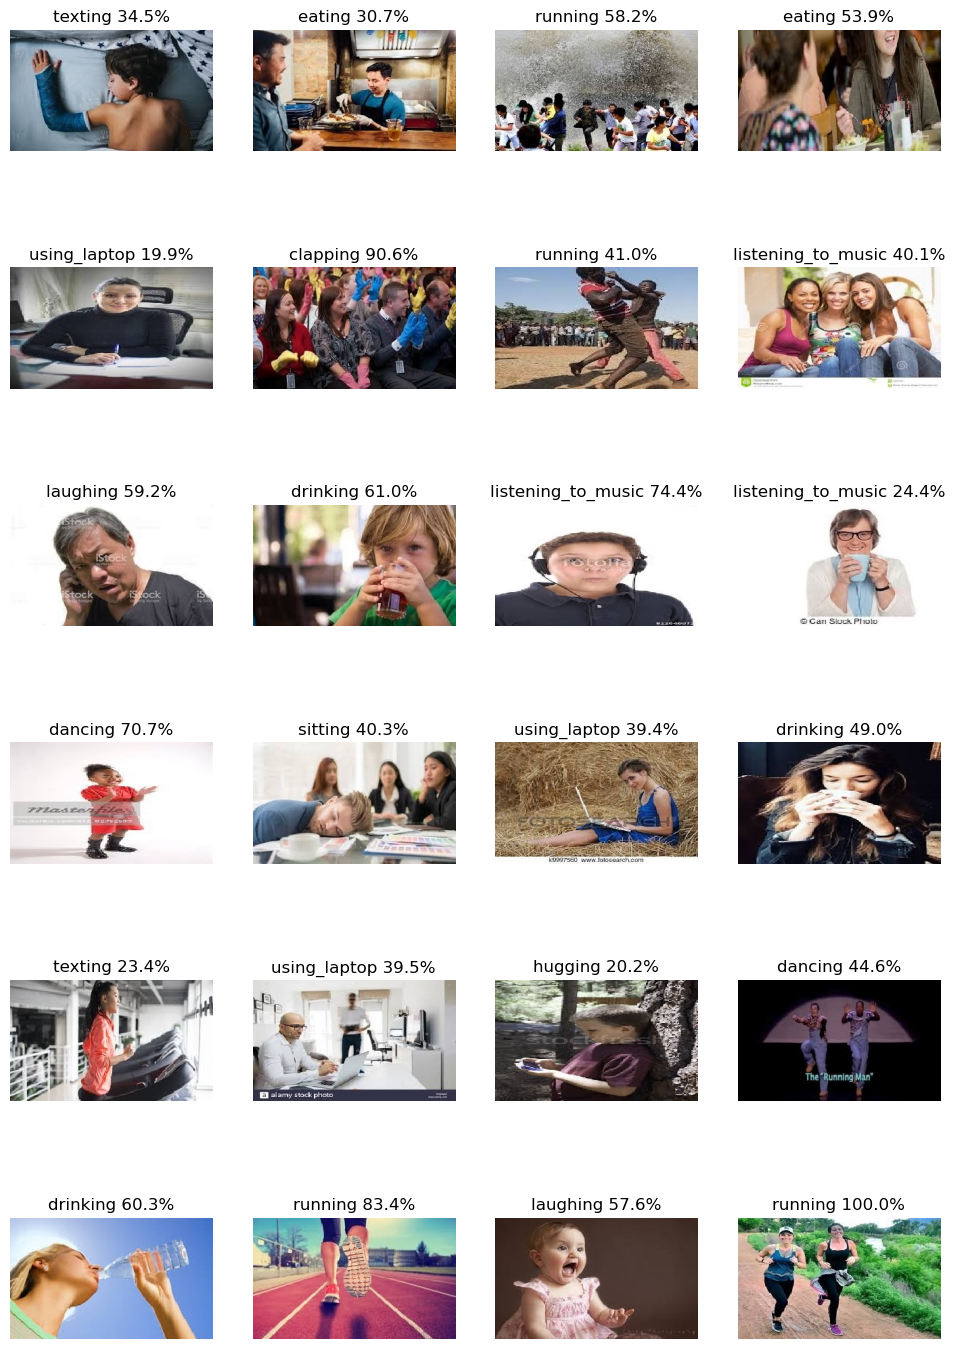

In [ ]:
test_generator.reset()
x = next(test_generator)
plot_images(x, None, vgg16_test_preds)

# Xception

In [ ]:
# load the xception architecture with imagenet weights as base
xception_base_model = tf.keras.applications.xception.Xception(
                                 include_top = False,
                                 weights = 'imagenet',
                                 input_shape = (image_height, image_width, 3)
                                 )

# For freezing the layer we make use of layer.trainable = False
# means that its internal state will not change during training.
# model's trainable weights will not be updated during fit(),
# and also its state updates will not run.
xception_model = create_model(xception_base_model)
#xception_model.summary()
history = fit_model(xception_model, xception_base_model, epochs = TRAINING_EPOCHS)

83683744/83683744 [==============================] - 0s 0us/step
Unfreezing number of layers in base model =  0
Epoch 1/5
355/355 [==============================] - 159s 435ms/step - loss: 1.8781 - accuracy: 0.4002 - val_loss: 1.2811 - val_accuracy: 0.6000
Epoch 2/5
355/355 [==============================] - 150s 421ms/step - loss: 1.5177 - accuracy: 0.5145 - val_loss: 1.1552 - val_accuracy: 0.6389
Epoch 3/5
355/355 [==============================] - 148s 418ms/step - loss: 1.4116 - accuracy: 0.5549 - val_loss: 1.1104 - val_accuracy: 0.6603
Epoch 4/5
355/355 [==============================] - 150s 422ms/step - loss: 1.3553 - accuracy: 0.5784 - val_loss: 1.0755 - val_accuracy: 0.6532
Epoch 5/5
355/355 [==============================] - 151s 424ms/step - loss: 1.3057 - accuracy: 0.5882 - val_loss: 1.0566 - val_accuracy: 0.6571


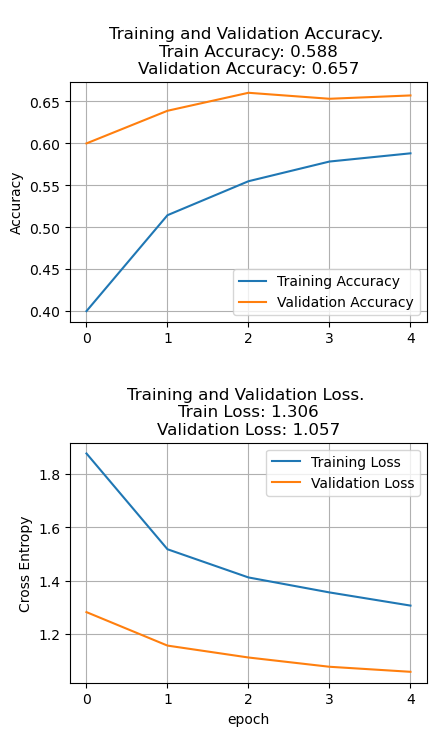

In [ ]:
plot_history(history)

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
nr_base_layers = len(xception_base_model.layers)
print("xception base layers = ", nr_base_layers)    

history = fit_model(xception_model, xception_base_model, epochs = FINE_TUNING_EPOCHS, fine_tune = int(nr_base_layers/4))

xception base layers =  132
Unfreezing number of layers in base model =  33
Epoch 1/12
355/355 [==============================] - 167s 439ms/step - loss: 1.4529 - accuracy: 0.5517 - val_loss: 1.0727 - val_accuracy: 0.6571
Epoch 2/12
355/355 [==============================] - 151s 424ms/step - loss: 1.2800 - accuracy: 0.5985 - val_loss: 1.0176 - val_accuracy: 0.6802
Epoch 3/12
355/355 [==============================] - 156s 439ms/step - loss: 1.1956 - accuracy: 0.6259 - val_loss: 0.9726 - val_accuracy: 0.6937
Epoch 4/12
355/355 [==============================] - 153s 429ms/step - loss: 1.1574 - accuracy: 0.6410 - val_loss: 0.9396 - val_accuracy: 0.7024
Epoch 5/12
355/355 [==============================] - 152s 429ms/step - loss: 1.0997 - accuracy: 0.6661 - val_loss: 0.9144 - val_accuracy: 0.7143
Epoch 6/12
355/355 [==============================] - 156s 438ms/step - loss: 1.0572 - accuracy: 0.6745 - val_loss: 0.8872 - val_accuracy: 0.7190
Epoch 7/12
355/355 [============================

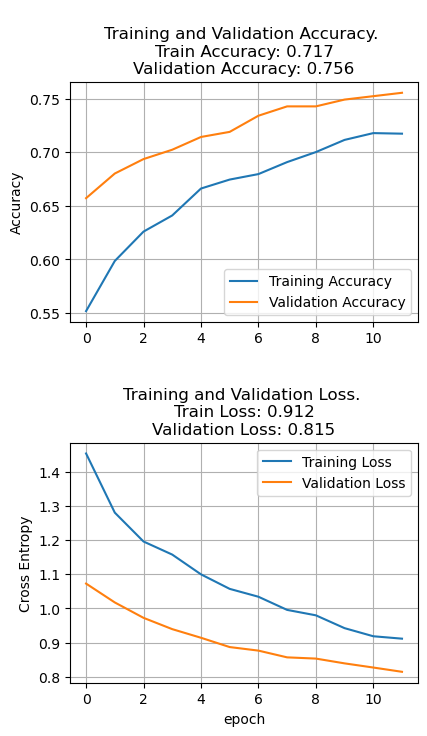

In [ ]:
plot_history(history)

In [ ]:
accuracy_score = xception_model.evaluate(validation_generator)

print(accuracy_score)
print("Accuracy: {:.2f}%".format(accuracy_score[1] * 100))
print("Loss: {:.3f}".format(accuracy_score[0]))

40/40 [==============================] - 3s 82ms/step - loss: 0.8149 - accuracy: 0.7556
[0.8149012923240662, 0.7555555701255798]
Accuracy: 75.56%
Loss: 0.815


In [ ]:
# Perform predictions to allow computation of the confusion matrix later on
# Do not shuffle predictions otherwise we have no way of finding out the true labels
validation_generator.reset()

xception_val_preds = xception_model.predict(validation_generator)
xception_val_pred_classes = np.argmax(xception_val_preds, axis = 1)

40/40 [==============================] - 4s 80ms/step


In [ ]:
# Perform predictions to allow computation of the confusion matrix later on
# Do not shuffle predictions otherwise we have no way of finding out the true labels
test_generator.reset()

xception_test_preds = xception_model.predict(test_generator)
xception_test_pred_classes = np.argmax(xception_test_preds, axis = 1)

169/169 [==============================] - 20s 117ms/step


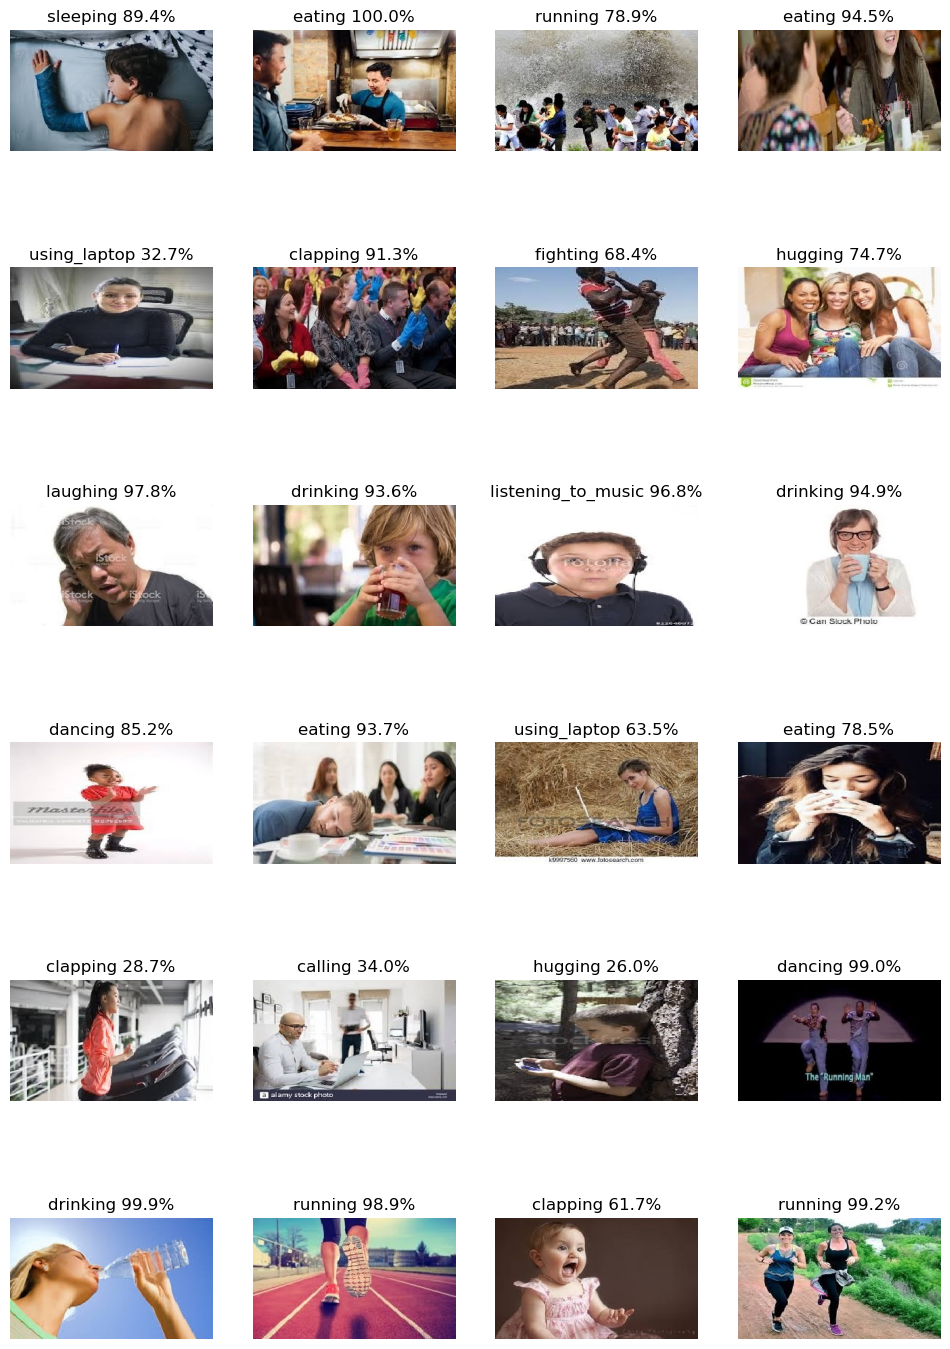

In [ ]:
test_generator.reset()
x = next(test_generator)
plot_images(x, None, xception_test_preds)

# Confusion Matrix

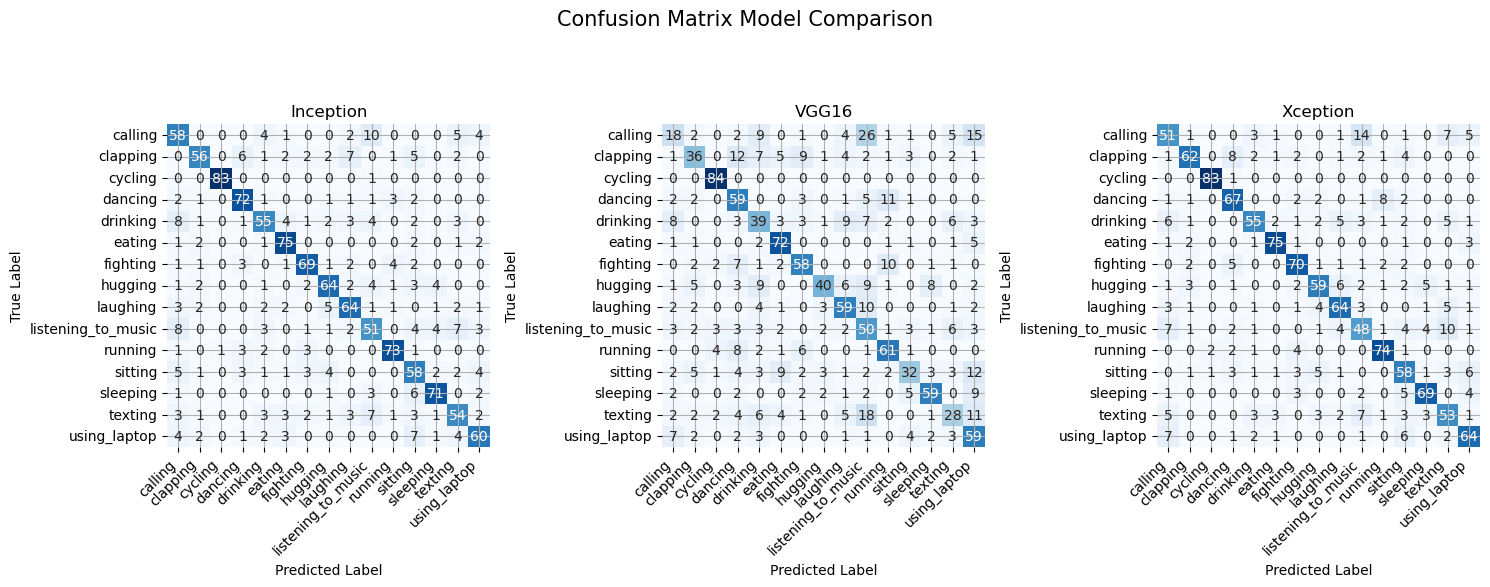

In [ ]:
# Display confusion matrix
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 8))

true_classes = validation_generator.classes

plot_heatmap(true_classes, inception_val_pred_classes, class_names, ax1, title = "Inception")    
plot_heatmap(true_classes, vgg16_val_pred_classes, class_names, ax2, title = "VGG16")    
plot_heatmap(true_classes, xception_val_pred_classes, class_names, ax3, title = "Xception")    

fig.suptitle("Confusion Matrix Model Comparison", fontsize = 15)
fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()